In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from labbench import stopwatch

import matplotlib.pyplot as plt

# this is a development environment hack!
# after pip install of sea_ingest, you'd just import sea_ingest
import sea_ingest


data_path = Path('data')
plt.style.use('ieee-publication-double-column.mplstyle')

### Multiprocessing aggregation (dask.dataframe)
This is shown aggregating a single trace type (pfp) since it loads a single dataframe.

In [2]:
from ziparchive import read_seamf_zipfile_as_ddf, restore_multiindex
import dask

with stopwatch():
    ddfs = sea_ingest.read_seamf_zipfile_as_ddf(
        data_path/'NIT-2022-12-13.zip',
        tz="America/New_York",
        localize=True
    )

    day_ddfs = {
        k: ddfs[k].loc['2022-11-01']
        for k in ('psd', 'pfp', 'pvt', 'channel_metadata')
    }

    day = dask.compute(day_ddfs, num_workers=8)[0]
    sea_ingest.restore_multiindex(day)

    for table_name in ('psd', 'pfp', 'pvt'):
        day[table_name] = day[table_name].astype('float32')

 INFO   2023-06-12 13:36:34.659 • labbench: 25.871 s elapsed


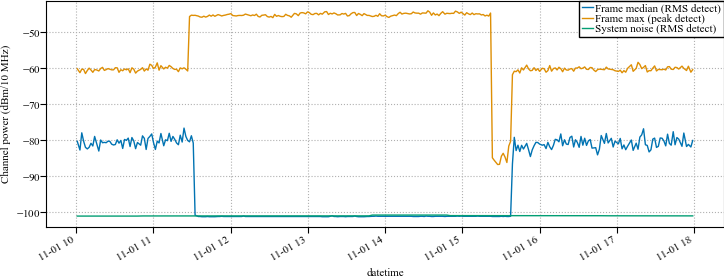

In [3]:
freq = 3605e6

pfp_indicators = {
    'Frame median (RMS detect)':
        sea_ingest.trace(day, 'pfp', frequency=freq, capture_statistic='mean', detector='rms').quantile(0.5, axis=1),
    'Frame max (peak detect)':
        sea_ingest.trace(day, 'pfp', frequency=freq, capture_statistic='max', detector='peak').max(axis=1),
    'System noise (RMS detect)':
        sea_ingest.trace(day, 'channel_metadata', 'cal_noise_figure_dB', frequency=freq) + -174 + 70 - 1
}

pfp_indicators = pd.concat(pfp_indicators, axis=1)

(
    pfp_indicators.loc['2022-11-01 10:00:00':'2022-11-01 18:00:00']
    .plot(ylabel='Channel power (dBm/10 MHz)')
);

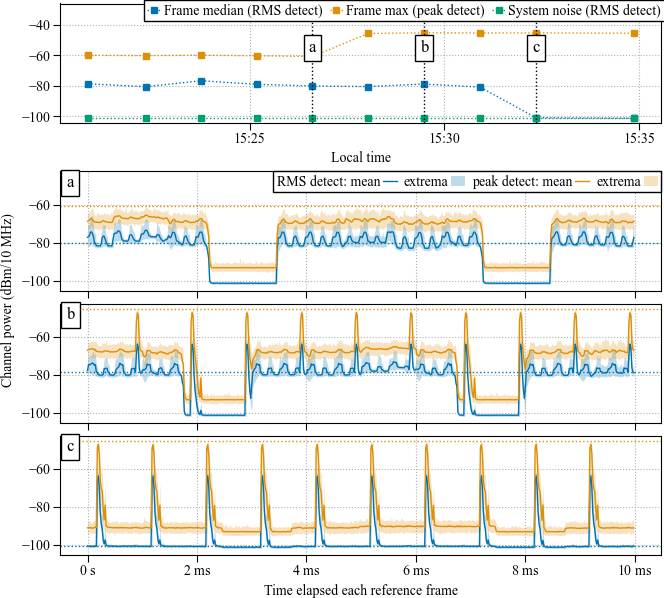

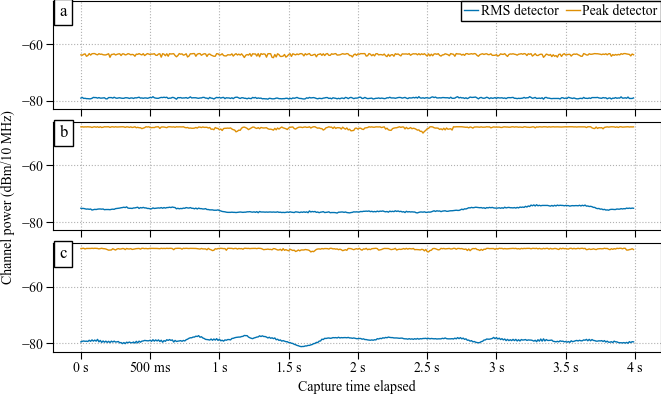

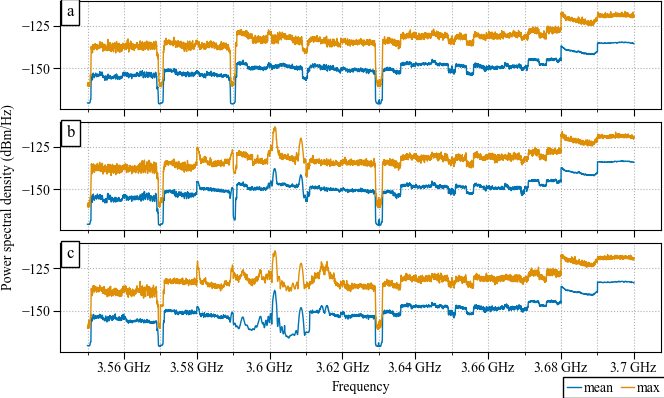

In [4]:
from plots import nearest_datetimes, plot_pfp_span_with_detail, plot_pvt_detail, plot_psd_detail

plt.style.use('report.mplstyle')

detail_trace_targets = {'a': '2022-11-01 11:26', 'b': '2022-11-01 11:30', 'c': '2022-11-01 11:33'}
mid_span = slice('2022-11-01 11:20:00','2022-11-01 11:35:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_start.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes)
fig.savefig('nit_event_2022-11_pvt_start.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_start.svg')

In [5]:
import plots

plots.pfp_traces

,Frame time elapsed (s),0.000000,0.000018,0.000036,0.000054,0.000071,0.000089,0.000107,0.000125,0.000143,0.000161,...,0.009821,0.009839,0.009857,0.009875,0.009893,0.009911,0.009929,0.009946,0.009964,0.009982
capture_statistic,detector,,,,,,,,,,,,,,,,,,,,,
min,rms,-101.2500,-101.6250,-101.3750,-101.4375,-101.5000,-101.5625,-101.5625,-101.4375,-101.3125,-101.3750,...,-101.2500,-101.3750,-101.3750,-101.3750,-101.3750,-101.4375,-101.6250,-101.7500,-101.5000,-101.3750
max,rms,-100.0625,-100.0000,-99.9375,-100.0625,-100.0625,-100.2500,-100.1875,-99.9375,-99.7500,-100.1250,...,-100.0625,-99.8125,-100.0625,-99.8750,-100.0000,-99.6875,-100.3750,-100.1875,-99.0000,-99.1875
mean,rms,-100.7500,-100.7500,-100.7500,-100.7500,-100.8125,-100.8125,-100.8125,-100.7500,-100.6875,-100.7500,...,-100.8125,-100.7500,-100.6875,-100.7500,-100.7500,-100.8125,-100.8750,-100.8750,-100.8125,-100.7500
min,peak,-93.7500,-94.4375,-93.7500,-93.8750,-94.0625,-93.8125,-94.1250,-93.8125,-93.6250,-93.7500,...,-94.1250,-94.0000,-93.6250,-93.9375,-93.2500,-93.8125,-95.0000,-93.6875,-94.0000,-93.8125
max,peak,-87.6250,-87.3125,-87.4375,-88.2500,-88.5000,-88.0000,-87.6250,-87.1250,-87.7500,-88.1250,...,-88.2500,-88.1250,-88.1250,-87.5000,-87.5625,-88.2500,-88.4375,-87.5625,-86.6875,-88.1250
mean,peak,-91.0625,-91.0000,-91.0000,-90.9375,-91.3125,-91.0625,-91.1875,-91.0000,-90.6875,-90.9375,...,-91.0625,-91.1875,-90.8750,-91.1250,-90.8750,-90.9375,-91.2500,-91.1250,-91.1875,-91.1250


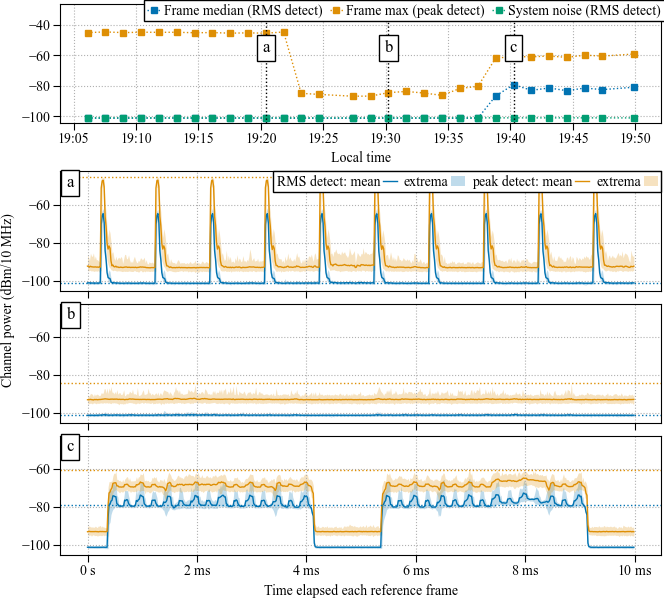

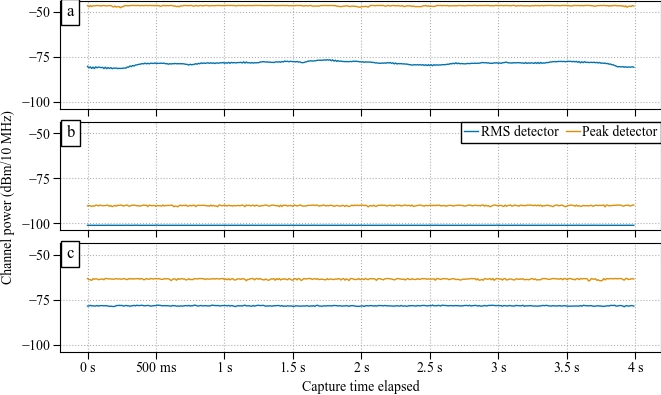

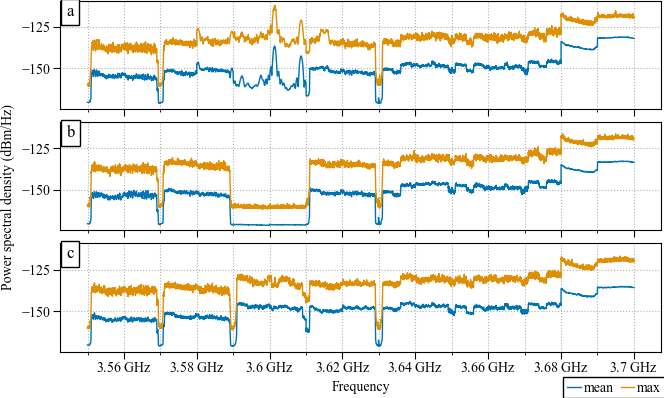

In [6]:
detail_trace_targets = {'a': '2022-11-01 15:20', 'b': '2022-11-01 15:30', 'c': '2022-11-01 15:40'}
mid_span = slice('2022-11-01 15:05:00','2022-11-01 15:50:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_end.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes, legend_ax_index=1)
plt.savefig('nit_event_2022-11_pvt_end.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_end.svg')